In [53]:
using OpenCL
using PyPlot
using Printf
using pocl_jll

# Native Julia Julia Set Implementation

In [54]:
w = 2048 * 2;
h = 2048 * 2;
@printf("Size %i MB\n", sizeof(ComplexF32) * w * h / 1024 / 1024)

Size 128 MB


In [55]:
# julia set
# (the familiar mandelbrot set is obtained by setting c==z initially)
function julia(z, maxiter)
    c = ComplexF32(-0.5, 0.75)
    for n = 1:maxiter
        if abs2(z) > 4.0
            return n-1
        end
        z = z*z + c
    end
    return maxiter
end

julia (generic function with 1 method)

In [56]:
q = [ComplexF32(r,i) for i=1:-(2.0/w):-1, r=-1.5:(3.0/h):1.5];

In [57]:
function ordinary_julia(q; maxiter=300)
    (h, w) = size(q)
    m  = Array{UInt8}(undef, (h, w));
    for i in 1:w
        for j in 1:h
            @inbounds v = q[j, i]
            @inbounds m[j, i] = julia(v, maxiter)
        end
    end
    return m
end

ordinary_julia (generic function with 1 method)

In [58]:
@time m = ordinary_julia(q; maxiter=300);

  0.141440 seconds (21.10 k allocations: 17.459 MiB, 19.74% compilation time)


In [59]:
get_cmap("RdGy")

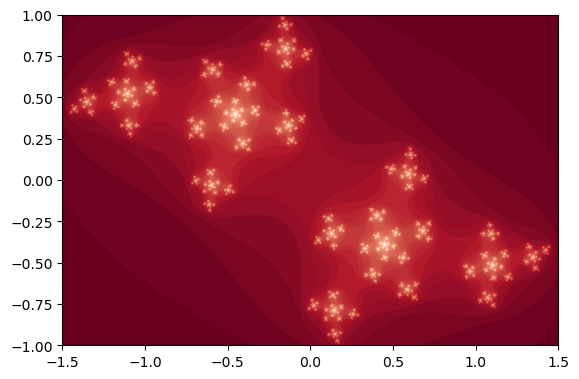

In [60]:
imshow(m, cmap="RdGy", extent=[-1.5,1.5,-1,1]);

In [61]:
julia_solution = deepcopy(m);

# OpenCL GPU Julia Set Implementation

Let us make the previous implementation compatible with OpenCL.  
    

In [62]:
julia_source = "

__kernel void julia(__global float2 *q,
                    __global ushort *output,
                    ushort const maxiter)
{
 int gid = get_global_id(0);
 float nreal = 0;
 float real  = q[gid].x;
 float imag  = q[gid].y;

 output[gid] = 0;

 for(int curiter = 0; curiter < maxiter; curiter++) {
     if (real*real + imag*imag > 4.0f) {
         output[gid] = curiter;
     }
     nreal = real*real - imag*imag + -0.5f;
     imag  = 2*real*imag + 0.75f;
     real = nreal;
  }
}";

In [63]:
function julia_opencl(q::Array{ComplexF32}; maxiter::Int64)
    out = Array{UInt16}(undef, size(q))

    q_buff = cl.Buffer(ComplexF32, length(q), (:r, :copy), hostbuf=q)
    o_buff = cl.Buffer(UInt16, length(out), :w)

    prg = cl.Program(source=julia_source) |> cl.build!
    k = cl.Kernel(prg, "julia")

    cl.call(k, q_buff, o_buff, UInt16(maxiter); global_size=length(q))
    cl.copy!(out, o_buff)

    return out
end


julia_opencl (generic function with 4 methods)

We can verify that the outputs are quite similar

In [64]:
opencl_solution = julia_opencl(q; maxiter=300);

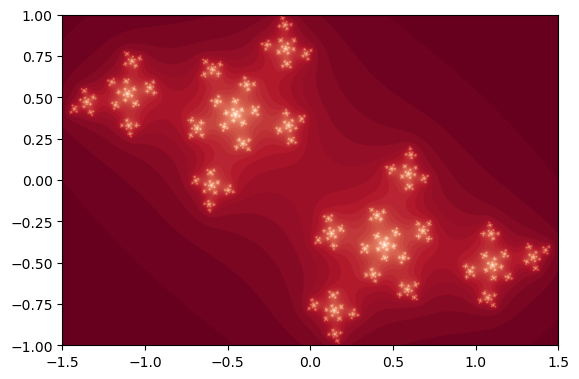

In [65]:
imshow(opencl_solution, cmap="RdGy", extent=[-1.5,1.5,-1,1]);

### OpenCL code portability

We can see that the code is portable but performance is not. If we select as device the CPU even though we are executing the same OpenCL code the performance is not as good.

#### Device 1: AMD Ryzen 9 5950X CPU via POCL

In [69]:
cl.platform!("pocl")

OpenCL.Platform('Portable Computing Language' @0x000076bdebde77e8)

In [70]:
cl.device()

OpenCL.Device(cpu-haswell-AMD Ryzen 9 5950X 16-Core Processor on Portable Computing Language @0x000000001e5b4d90)

In [78]:
@time julia_opencl(q; maxiter=100);

  0.207748 seconds (80 allocations: 32.021 MiB)


In [79]:
@time julia_opencl(q; maxiter=200);

  0.348160 seconds (80 allocations: 32.021 MiB)


In [80]:
@time julia_opencl(q; maxiter=1000);

  1.319786 seconds (80 allocations: 32.021 MiB)


#### Device 2: Intel ARC A770 GPU

In [83]:
cl.platform!("intel")

OpenCL.Platform('Intel(R) OpenCL Graphics' @0x000000001ddb1e30)

In [84]:
cl.device()

OpenCL.Device(Intel(R) Arc(TM) A770 Graphics on Intel(R) OpenCL Graphics @0x000000001cbc8fd0)

In [87]:
@time julia_opencl(q; maxiter=100);

  0.024177 seconds (80 allocations: 32.021 MiB)


In [88]:
@time julia_opencl(q; maxiter=200);

  0.027999 seconds (80 allocations: 32.021 MiB)


In [89]:
@time julia_opencl(q; maxiter=1000);

  0.046878 seconds (80 allocations: 32.021 MiB)


#### Device 3: NVIDIA RTX 6000 GPU

In [90]:
cl.platform!("nvidia")

OpenCL.Platform('NVIDIA CUDA' @0x000000001e8f8dc0)

In [91]:
cl.device()

OpenCL.Device(NVIDIA RTX 6000 Ada Generation on NVIDIA CUDA @0x000000001e583a00)

In [93]:
@time julia_opencl(q; maxiter=100);

  0.033076 seconds (80 allocations: 32.021 MiB)


In [94]:
@time julia_opencl(q; maxiter=200);

  0.033437 seconds (80 allocations: 32.021 MiB)


In [95]:
@time julia_opencl(q; maxiter=1000);

  0.036552 seconds (80 allocations: 32.021 MiB)
